In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyro-ppl
!pip install arviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
from pyro.infer import MCMC, NUTS, Predictive
from pyro.infer.autoguide import AutoNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import arviz as az
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import norm
from graphviz import Digraph

In [4]:
working_dir = '/content/drive/MyDrive/COM3023'
os.chdir(working_dir)

### Prepare Data and define BNN

In [5]:
data = load_breast_cancer()

# Create a DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

x = df.drop(columns=["target"]).values
y = df["target"].values

x = scale(x)

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)

x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_val = torch.tensor(x_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [6]:
class BNN(PyroModule):
    def __init__(self, in_dim=30, out_dim=1, hid_dim=15, prior_scale=1., device='cpu'):
        super().__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim
        self.device = device

        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)
        self.layer2 = PyroModule[nn.Linear](hid_dim, hid_dim)
        self.layer3 = PyroModule[nn.Linear](hid_dim, hid_dim)
        self.layer4 = PyroModule[nn.Linear](hid_dim, out_dim)

        self.bn1 = nn.BatchNorm1d(hid_dim)
        self.bn2 = nn.BatchNorm1d(hid_dim)
        self.bn3 = nn.BatchNorm1d(hid_dim)
        self.bn4 = nn.BatchNorm1d(hid_dim)

        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))

        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))

        self.layer3.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, hid_dim]).to_event(2))
        self.layer3.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))

        self.layer4.weight = PyroSample(dist.Normal(0., prior_scale).expand([out_dim, hid_dim]).to_event(2))
        self.layer4.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim]).to_event(1))

        self.to(device)

    def forward(self, x, y=None, plate_name='data'):
        x = x.reshape(-1, self.in_dim)
        x = nn.functional.relu(self.layer1(x))
        x = self.bn1(x)
        x = nn.functional.relu(self.layer2(x))
        x = self.bn2(x)
        x = nn.functional.relu(self.layer3(x))
        x = self.bn3(x)

        mu = torch.sigmoid(self.layer4(x).squeeze())
        with pyro.plate(plate_name, x.shape[0]):
            obs = pyro.sample("obs", dist.Bernoulli(probs=mu), obs=y)

        return mu

In [ ]:
# Create a new directed graph
dot = Digraph()

# Input node
dot.node('Input', 'Input Layer\n(30 dimensions)')

# Layers and operations
dot.node('L1', 'Layer 1\n(15 dimensions)')
dot.node('ReLU1', 'ReLU')
dot.node('BN1', 'Batch Norm 1')

dot.node('L2', 'Layer 2\n(15 dimensions)')
dot.node('ReLU2', 'ReLU')
dot.node('BN2', 'Batch Norm 2')

dot.node('L3', 'Layer 3\n(15 dimensions)')
dot.node('ReLU3', 'ReLU')
dot.node('BN3', 'Batch Norm 3')

dot.node('L4', 'Layer 4\n(1 dimension)')
dot.node('Sigmoid', 'Sigmoid')

# Output node
dot.node('Output', 'Output\nBernoulli(probs=mu)')

# Adding edges
dot.edge('Input', 'L1', label='Linear + Normal Priors')
dot.edge('L1', 'ReLU1')
dot.edge('ReLU1', 'BN1')
dot.edge('BN1', 'L2', label='Linear + Normal Priors')
dot.edge('L2', 'ReLU2')
dot.edge('ReLU2', 'BN2')
dot.edge('BN2', 'L3', label='Linear + Normal Priors')
dot.edge('L3', 'ReLU3')
dot.edge('ReLU3', 'BN3')
dot.edge('BN3', 'L4', label='Linear + Normal Priors')
dot.edge('L4', 'Sigmoid')
dot.edge('Sigmoid', 'Output')

# Render the graph to a file (e.g., PDF or PNG)
dot.render('neural_network', format='png', view=True)

'neural_network.png'

### Feature Importance

In [ ]:
# Compute Spearman correlation
correlations = df.corr(method='spearman')

# Sort correlations with Diabetes Outcome
correlations['target'].sort_values(ascending=False)

,target
target,1.000000
symmetry error,0.092303
smoothness error,0.052193
mean fractal dimension,0.025903
texture error,-0.019419
fractal dimension error,-0.201492
worst fractal dimension,-0.311477
mean symmetry,-0.332567
mean smoothness,-0.371892
compactness error,-0.380666


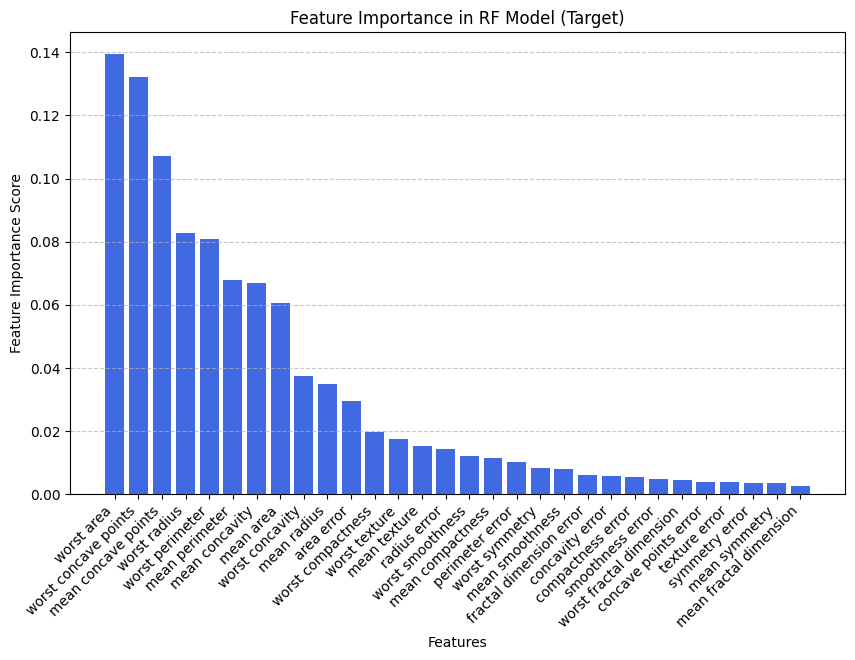

In [ ]:
# Random Forest Feature Importance

X = df.drop(columns=["target"])
Y = df["target"]

# Train a Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, Y)

# Get feature importances
importances = rf.feature_importances_
feature_importance = pd.DataFrame({"Feature": X.columns, "Importance": importances})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance["Feature"], feature_importance["Importance"], color="royalblue")

plt.xticks(rotation=45, ha="right")

# Add labels and title
plt.xlabel("Features")
plt.ylabel("Feature Importance Score")
plt.title("Feature Importance in RF Model (Target)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

Model Accuracy: 0.96


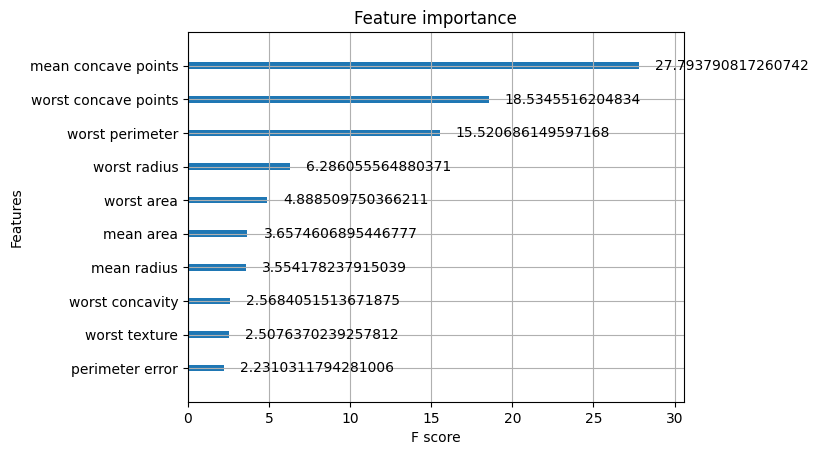

In [ ]:
# XGBoost Feature Importance
X = df.drop(columns=["target"])
Y = df["target"]

# Split dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize XGBoost classifier
model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the model
model.fit(X_train, Y_train)

# Evaluate the model
Y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

xgb.plot_importance(model, importance_type="gain", max_num_features=10)  # Top 10 features
plt.show()

### MCMC

In [ ]:
pyro.clear_param_store()

model = BNN()

nuts_kernel = NUTS(model, target_accept_prob=0.7)
mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=200, num_chains=2)
mcmc.run(x_train, y_train)

/usr/local/lib/python3.11/dist-packages/pyro/infer/mcmc/api.py:499: UserWarning: num_chains=2 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(
Sample [1]: 100%|██████████| 2200/2200 [38:59,  1.06s/it, step size=3.15e-02, acc. prob=0.717]


/usr/local/lib/python3.11/dist-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


array([[<Axes: title={'center': 'layer1.bias'}>,
        <Axes: title={'center': 'layer1.bias'}>],
       [<Axes: title={'center': 'layer1.weight'}>,
        <Axes: title={'center': 'layer1.weight'}>],
       [<Axes: title={'center': 'layer2.bias'}>,
        <Axes: title={'center': 'layer2.bias'}>],
       [<Axes: title={'center': 'layer2.weight'}>,
        <Axes: title={'center': 'layer2.weight'}>],
       [<Axes: title={'center': 'layer3.bias'}>,
        <Axes: title={'center': 'layer3.bias'}>],
       [<Axes: title={'center': 'layer3.weight'}>,
        <Axes: title={'center': 'layer3.weight'}>],
       [<Axes: title={'center': 'layer4.bias'}>,
        <Axes: title={'center': 'layer4.bias'}>],
       [<Axes: title={'center': 'layer4.weight'}>,
        <Axes: title={'center': 'layer4.weight'}>]], dtype=object)

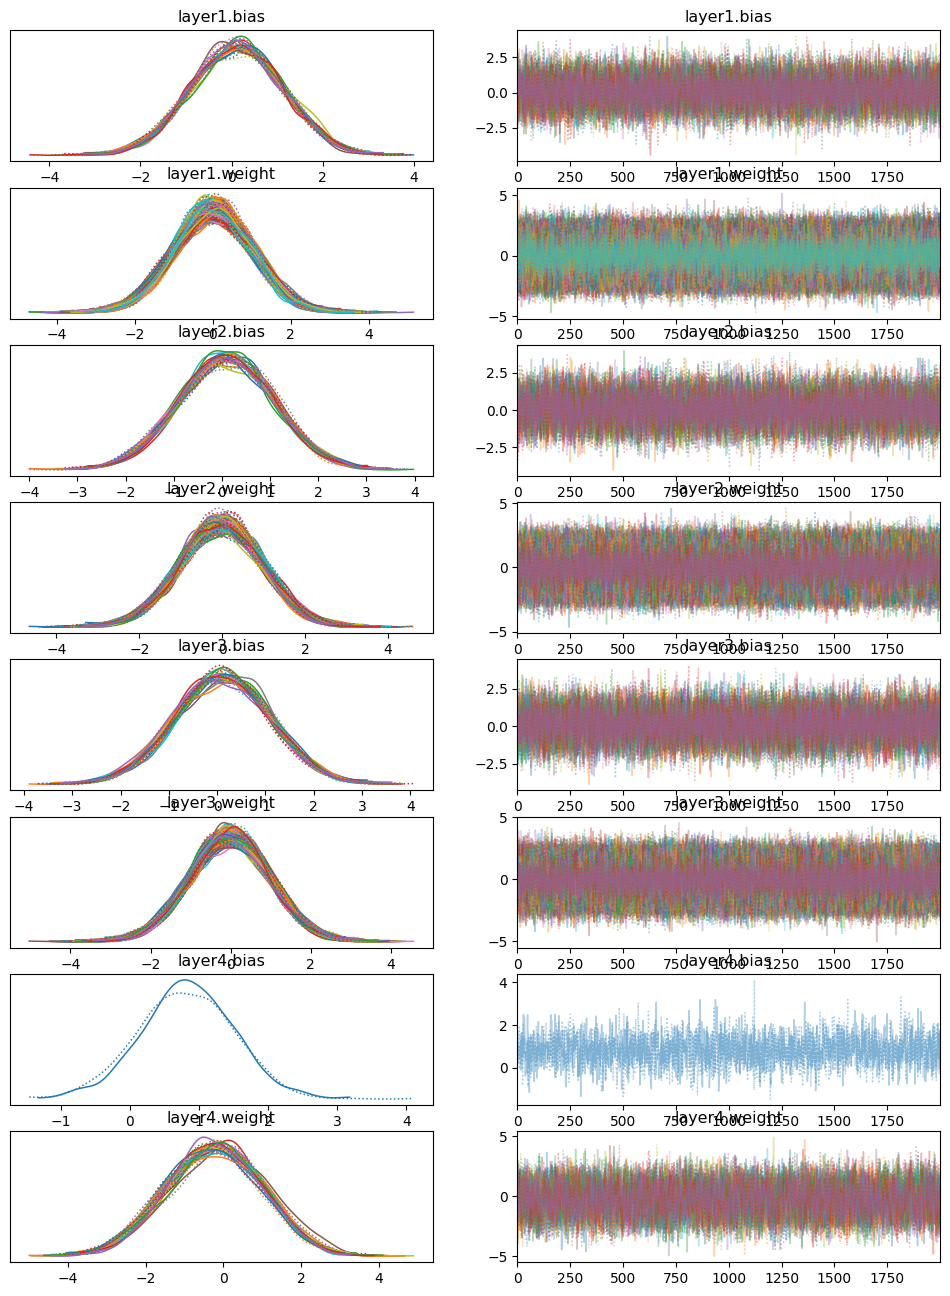

In [ ]:
posterior = az.from_pyro(mcmc)
az.plot_trace(posterior)

In [ ]:
posterior_samples = mcmc.get_samples()
print(posterior_samples.keys())

torch.save(posterior_samples, "mcmc_samples.pt")

dict_keys(['layer1.bias', 'layer1.weight', 'layer2.bias', 'layer2.weight', 'layer3.bias', 'layer3.weight', 'layer4.bias', 'layer4.weight'])


In [7]:
posterior_samples = torch.load("mcmc_samples.pt")
print(posterior_samples.keys())

dict_keys(['layer1.bias', 'layer1.weight', 'layer2.bias', 'layer2.weight', 'layer3.bias', 'layer3.weight', 'layer4.bias', 'layer4.weight'])


In [8]:
model = BNN()

predictive_mcmc = Predictive(model=model, posterior_samples=posterior_samples)
preds_mcmc = predictive_mcmc(x_test)
preds_mcmc_list = preds_mcmc['obs'].tolist()
y_test_list = y_test.tolist()

In [9]:
print(np.asarray(preds_mcmc_list).shape)
print(np.asarray(y_test_list).shape)

(4000, 86)
(86,)


In [10]:
accuracies = []
f1_scores = []

for sample_preds in preds_mcmc_list:
    accuracies.append(accuracy_score(y_test_list, sample_preds))
    f1_scores.append(f1_score(y_test_list, sample_preds))

average_accuracy = np.mean(accuracies)
average_f1 = np.mean(f1_scores)

print(f"Individual Average Accuracy: {average_accuracy:.4f}")
print(f"Individual Average F1-score: {average_f1:.4f}")

Individual Average Accuracy: 0.9335
Individual Average F1-score: 0.9503


Ensemble Accuracy: 0.9884
Ensemble F1-score: 0.9916


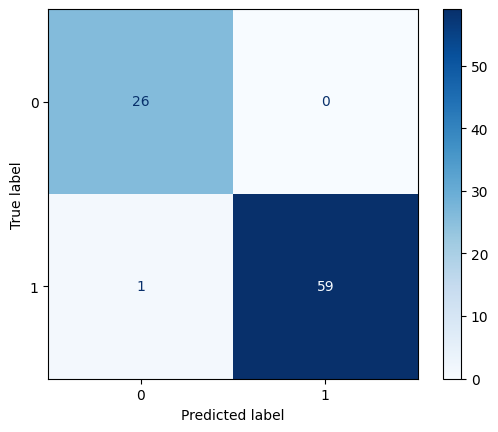

In [11]:
# Aggregate predictions by majority vote across all posterior samples
preds_array = np.array(preds_mcmc_list)
ensemble_preds = np.round(np.mean(preds_array, axis=0)).astype(int)

ensemble_accuracy = accuracy_score(y_test_list, ensemble_preds)
ensemble_f1 = f1_score(y_test_list, ensemble_preds)

# Create confusion matrix
cm = confusion_matrix(y_test_list, ensemble_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")
print(f"Ensemble F1-score: {ensemble_f1:.4f}")

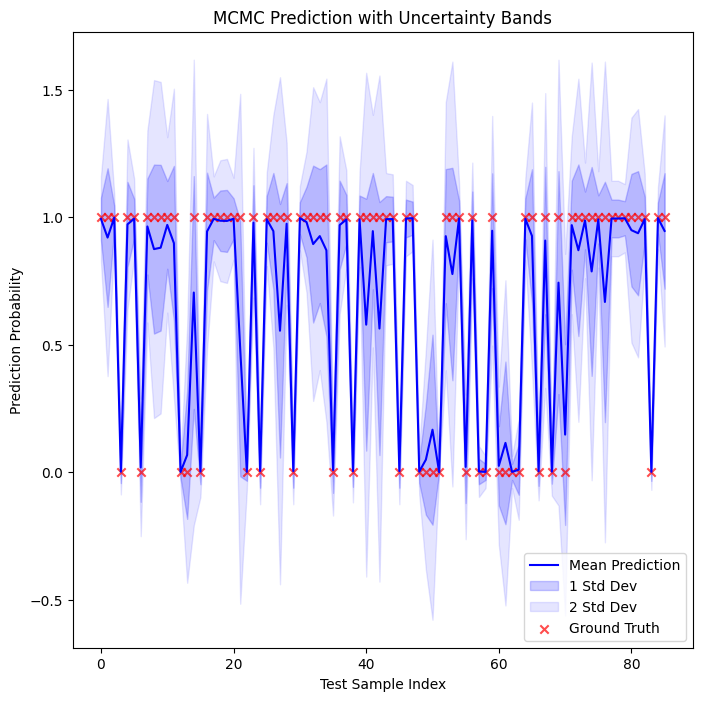

In [23]:
preds_array = np.array(preds_mcmc_list)

# Calculate the mean and standard deviation across samples
mean_preds = np.mean(preds_array, axis=0)
std_preds = np.std(preds_array, axis=0)

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(mean_preds, label='Mean Prediction', color='blue')

# Plot the uncertainty bands
ax.fill_between(
    np.arange(len(mean_preds)),
    mean_preds - std_preds,
    mean_preds + std_preds,
    color='blue', alpha=0.2, label='1 Std Dev'
)
ax.fill_between(
    np.arange(len(mean_preds)),
    mean_preds - 2 * std_preds,
    mean_preds + 2 * std_preds,
    color='blue', alpha=0.1, label='2 Std Dev'
)

# Ground truth overlay
ax.scatter(np.arange(len(y_test_list)), y_test_list, color='red', label='Ground Truth', alpha=0.7, marker='x')

# Labels and legend
ax.set_xlabel('Test Sample Index')
ax.set_ylabel('Prediction Probability')
ax.set_title('MCMC Prediction with Uncertainty Bands')
ax.legend()
plt.show()


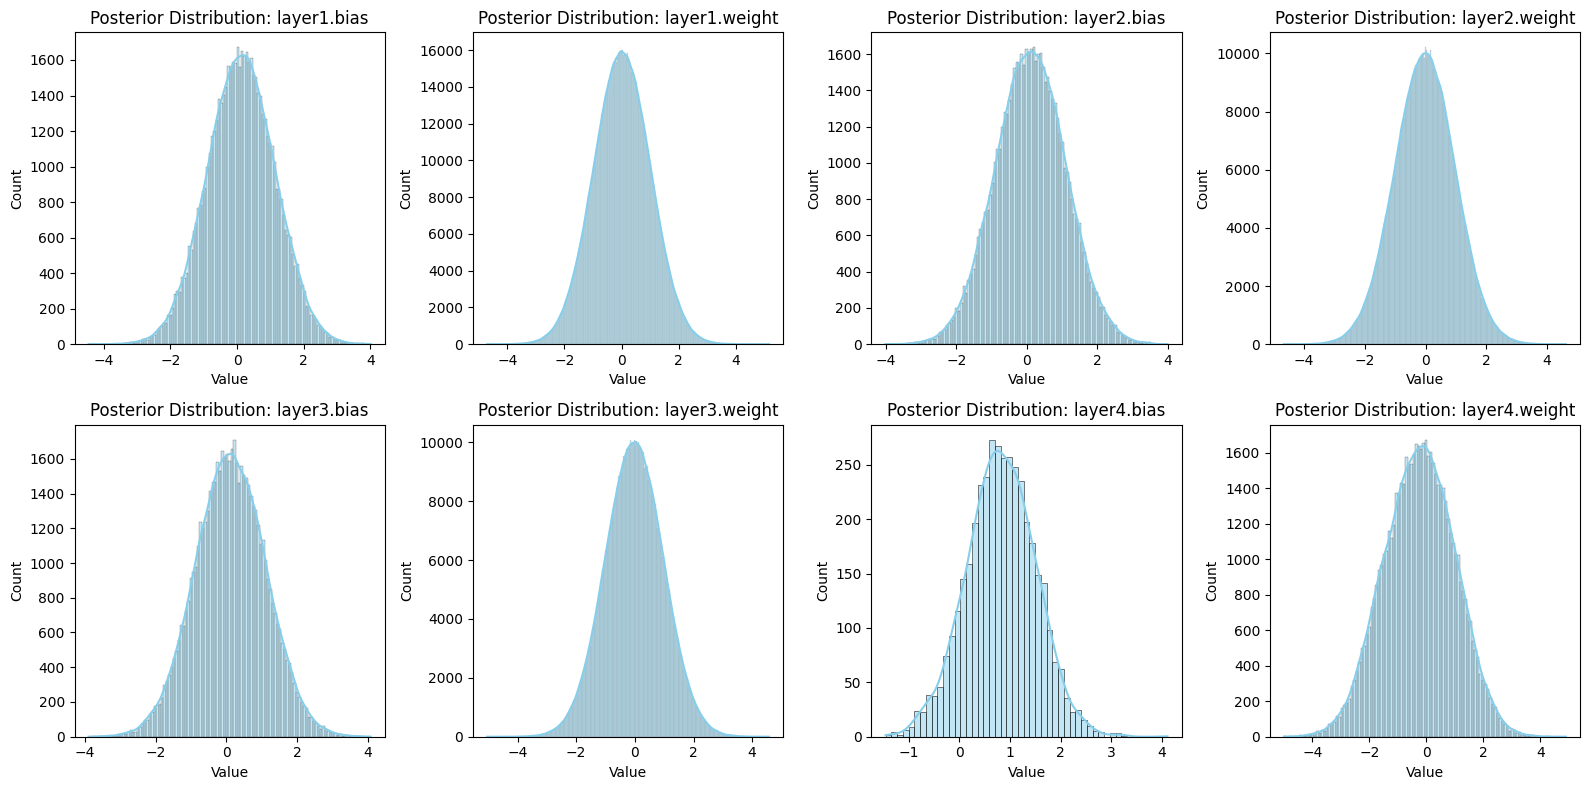

In [ ]:
param_names = list(posterior_samples.keys())

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, param in enumerate(param_names):
    samples = posterior_samples[param].detach().numpy()
    samples = samples.flatten()

    # Plot posterior distribution
    sns.histplot(samples, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Posterior Distribution: {param}')
    axes[i].set_xlabel('Value')

plt.tight_layout()
plt.show()


### Variational Inference

Iteration 0 - Loss: 21.13796027688419
Iteration 1000 - Loss: 1.4324649586397058
Iteration 2000 - Loss: 0.8156781364889706
Iteration 3000 - Loss: 0.6450568704044117
Iteration 4000 - Loss: 0.6532212201286764
Iteration 5000 - Loss: 0.6213350183823529
Iteration 6000 - Loss: 0.6615794462316177
Iteration 7000 - Loss: 0.457421875
Iteration 8000 - Loss: 0.5899342256433824
Early stopping triggered at epoch 8881


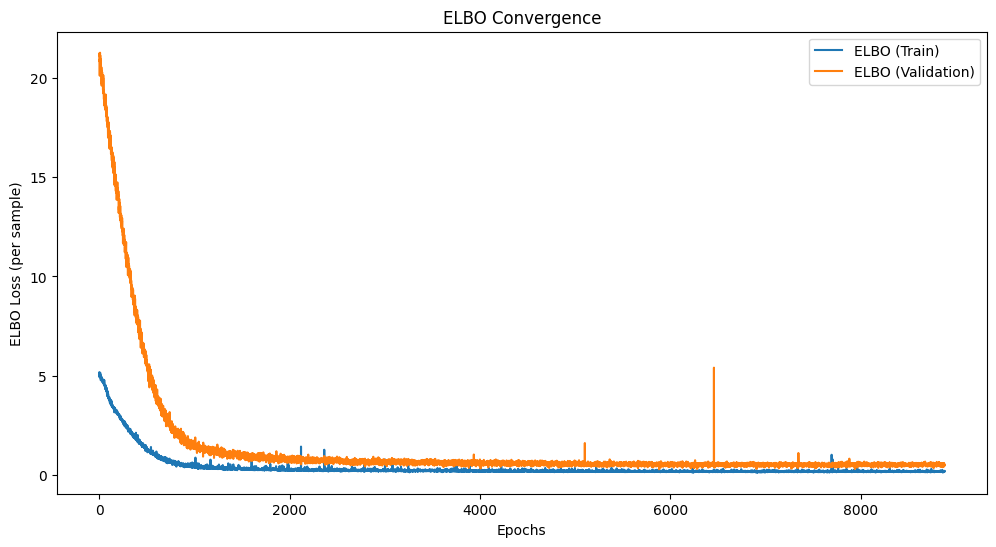

In [12]:
pyro.clear_param_store()

model = BNN()

guide = AutoNormal(model)

# Setup optimizer and SVI
# optimizer = Adam({"lr": 0.001})
optimizer = pyro.optim.AdamW({"lr": 0.005})
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

num_iterations = 20000
patience = 3000
min_delta = 1e-5

best_loss = float("inf")
patience_counter = 0

training_losses = []
validation_losses = []
for epoch in range(num_iterations):
    loss = svi.step(x_train, y_train)
    scaled_loss = loss / x_train.shape[0]
    training_losses.append(scaled_loss)

    with torch.no_grad():
        val_loss = svi.evaluate_loss(x_val, y_val)
        scaled_val_loss = val_loss / x_val.shape[0]
        validation_losses.append(scaled_val_loss)

    if epoch % 1000 == 0:
        print(f"Iteration {epoch} - Loss: {scaled_val_loss}")

    # Early stopping logic
    if scaled_val_loss < best_loss:
        best_loss = scaled_val_loss
        patience_counter = 0  # Reset counter if improved
    else:
        patience_counter += 1

    if patience_counter > (patience - 1):
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

plt.figure(figsize=(12, 6))
plt.plot(training_losses, label="ELBO (Train)")
plt.plot(validation_losses, label="ELBO (Validation)")
plt.xlabel("Epochs")
plt.ylabel("ELBO Loss (per sample)")
plt.title("ELBO Convergence")
plt.legend()
plt.show()

pyro.get_param_store().save("vi_params.pt")

In [13]:
# lr: 0.001 - 0.33813763786764706
# lr: 0.005 - 0.2828857421875
# lr: 0.005 - 0.4380457261029412 (early stopper)
# lr: 0.01 - 0.3437456916360294 (early stopper)
# lr: 0.01 - 0.2775979434742647 (early stopper)
print(min(validation_losses))

0.2898380055147059


In [14]:
vi_params = torch.load("vi_params.pt", weights_only=False)['params']
print(vi_params.keys())

dict_keys(['bn1$$$weight', 'bn1$$$bias', 'bn2$$$weight', 'bn2$$$bias', 'bn3$$$weight', 'bn3$$$bias', 'AutoNormal.locs.layer1.weight', 'AutoNormal.scales.layer1.weight', 'AutoNormal.locs.layer1.bias', 'AutoNormal.scales.layer1.bias', 'AutoNormal.locs.layer2.weight', 'AutoNormal.scales.layer2.weight', 'AutoNormal.locs.layer2.bias', 'AutoNormal.scales.layer2.bias', 'AutoNormal.locs.layer3.weight', 'AutoNormal.scales.layer3.weight', 'AutoNormal.locs.layer3.bias', 'AutoNormal.scales.layer3.bias', 'AutoNormal.locs.layer4.weight', 'AutoNormal.scales.layer4.weight', 'AutoNormal.locs.layer4.bias', 'AutoNormal.scales.layer4.bias'])


In [15]:
model = BNN()

predictive_vi = Predictive(model=model, guide=guide, num_samples=4000)
preds_vi = predictive_vi(x_test)
preds_vi_list = preds_vi['obs'].tolist()
y_test_list = y_test.tolist()

In [16]:
print(np.asarray(preds_vi_list).shape)
print(np.asarray(y_test_list).shape)

(4000, 86)
(86,)


In [17]:
accuracies = []
f1_scores = []

for sample_preds in preds_vi_list:
    accuracies.append(accuracy_score(y_test_list, sample_preds))
    f1_scores.append(f1_score(y_test_list, sample_preds))

average_accuracy = np.mean(accuracies)
average_f1 = np.mean(f1_scores)

print(f"Individual Average Accuracy: {average_accuracy:.4f}")
print(f"Individual Average F1-score: {average_f1:.4f}")

Individual Average Accuracy: 0.5229
Individual Average F1-score: 0.6064


Ensemble Accuracy: 0.7442
Ensemble F1-score: 0.8358


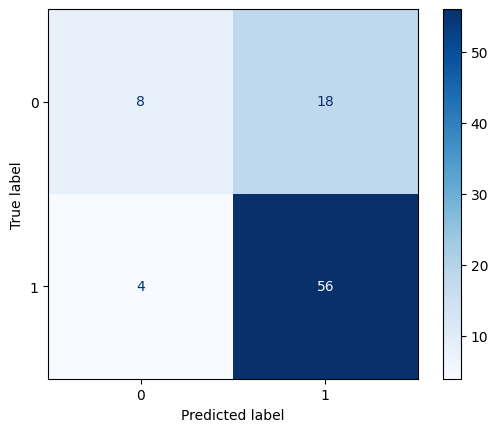

In [18]:
# Aggregate predictions by majority vote across all posterior samples
preds_array = np.array(preds_vi_list)
ensemble_preds = np.round(np.mean(preds_array, axis=0)).astype(int)

ensemble_accuracy = accuracy_score(y_test_list, ensemble_preds)
ensemble_f1 = f1_score(y_test_list, ensemble_preds)

# Create confusion matrix
cm = confusion_matrix(y_test_list, ensemble_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")
print(f"Ensemble F1-score: {ensemble_f1:.4f}")

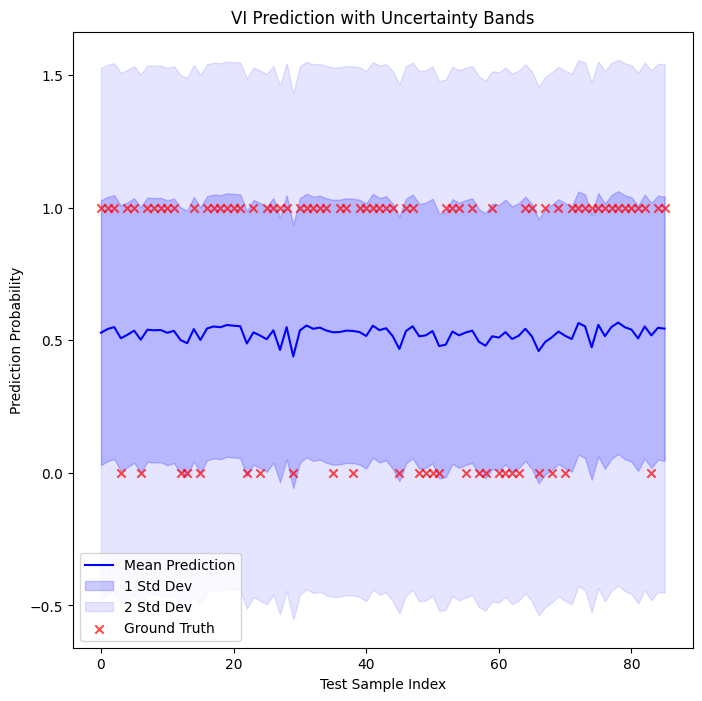

In [22]:
preds_array = np.array(preds_vi_list)

# Calculate the mean and standard deviation across samples
mean_preds = np.mean(preds_array, axis=0)
std_preds = np.std(preds_array, axis=0)

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(mean_preds, label='Mean Prediction', color='blue')

# Plot the uncertainty bands
ax.fill_between(
    np.arange(len(mean_preds)),
    mean_preds - std_preds,
    mean_preds + std_preds,
    color='blue', alpha=0.2, label='1 Std Dev'
)
ax.fill_between(
    np.arange(len(mean_preds)),
    mean_preds - 2 * std_preds,
    mean_preds + 2 * std_preds,
    color='blue', alpha=0.1, label='2 Std Dev'
)

# Ground truth overlay
ax.scatter(np.arange(len(y_test_list)), y_test_list, color='red', label='Ground Truth', alpha=0.7, marker='x')

# Labels and legend
ax.set_xlabel('Test Sample Index')
ax.set_ylabel('Prediction Probability')
ax.set_title('VI Prediction with Uncertainty Bands')
ax.legend()
plt.show()


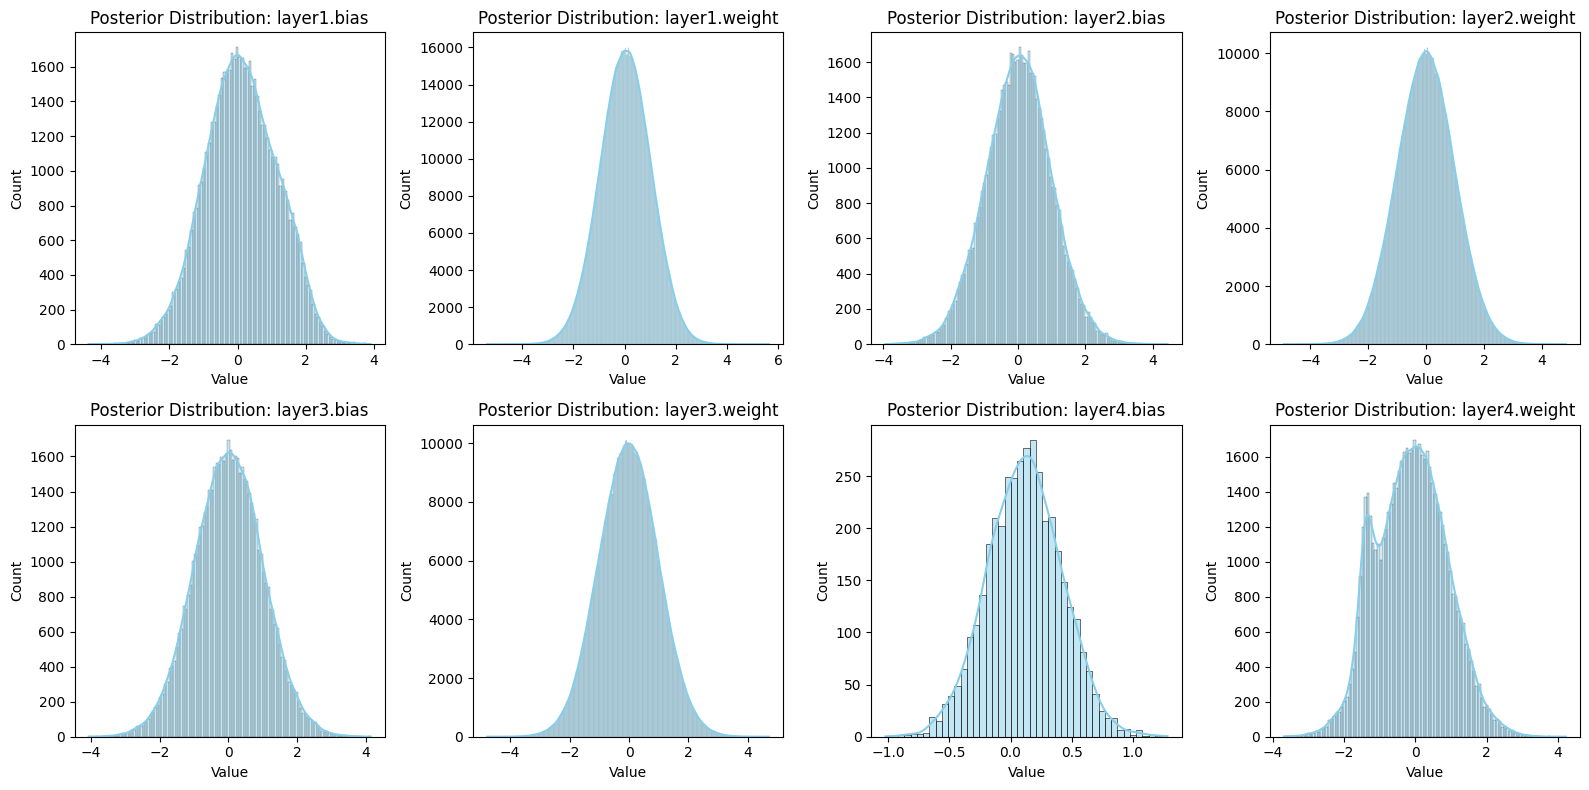

In [ ]:
# Separate biases and weights
bias_params = [name for name in preds_vi.keys() if 'bias' in name]
weight_params = [name for name in preds_vi.keys() if 'weight' in name]

# Sort to ensure matching order (layer1.bias → layer1.weight → ...)
bias_params.sort()
weight_params.sort()

# Interleave biases and weights
param_names = [param for pair in zip(bias_params, weight_params) for param in pair]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, param in enumerate(param_names):
    samples = preds_vi[param].flatten()

    # Plot posterior distribution
    sns.histplot(samples, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Posterior Distribution: {param}')
    axes[i].set_xlabel('Value')

plt.tight_layout()
plt.show()


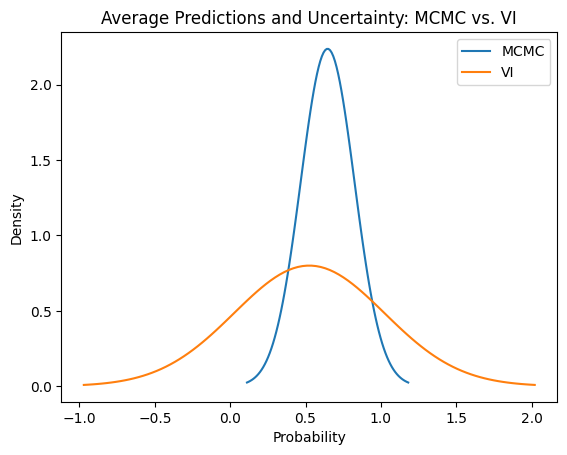

In [21]:
preds_mcmc_obs = preds_mcmc['obs'].detach().numpy()
mean_preds_mcmc = np.mean(preds_mcmc_obs, axis=0)
std_preds_mcmc = np.std(preds_mcmc_obs, axis=0)

mean_preds_mcmc_all = np.mean(mean_preds_mcmc)
std_preds_mcmc_all = np.mean(std_preds_mcmc)

preds_vi_obs = preds_vi['obs'].detach().numpy()
mean_preds_vi = np.mean(preds_vi_obs, axis=0)
std_preds_vi = np.std(preds_vi_obs, axis=0)

mean_preds_vi_all = np.mean(mean_preds_vi)
std_preds_vi_all = np.mean(std_preds_vi)

x_values_vi = np.linspace(mean_preds_mcmc_all - 3 * std_preds_mcmc_all, mean_preds_mcmc_all + 3 * std_preds_mcmc_all, 100)
plt.plot(x_values_vi, norm.pdf(x_values_vi, mean_preds_mcmc_all, std_preds_mcmc_all), label='MCMC')

x_values_mcmc = np.linspace(mean_preds_vi_all - 3 * std_preds_vi_all, mean_preds_vi_all + 3 * std_preds_vi_all, 100)
plt.plot(x_values_mcmc, norm.pdf(x_values_mcmc, mean_preds_vi_all, std_preds_vi_all), label='VI')

plt.xlabel('Probability')
plt.ylabel('Density')
plt.title('Average Predictions and Uncertainty: MCMC vs. VI')
plt.legend()
plt.show()